# Schematic

**Mutation load**: the total number of genetic mutations a patient carries.

TCGA: The Cancer Genome Atlas.

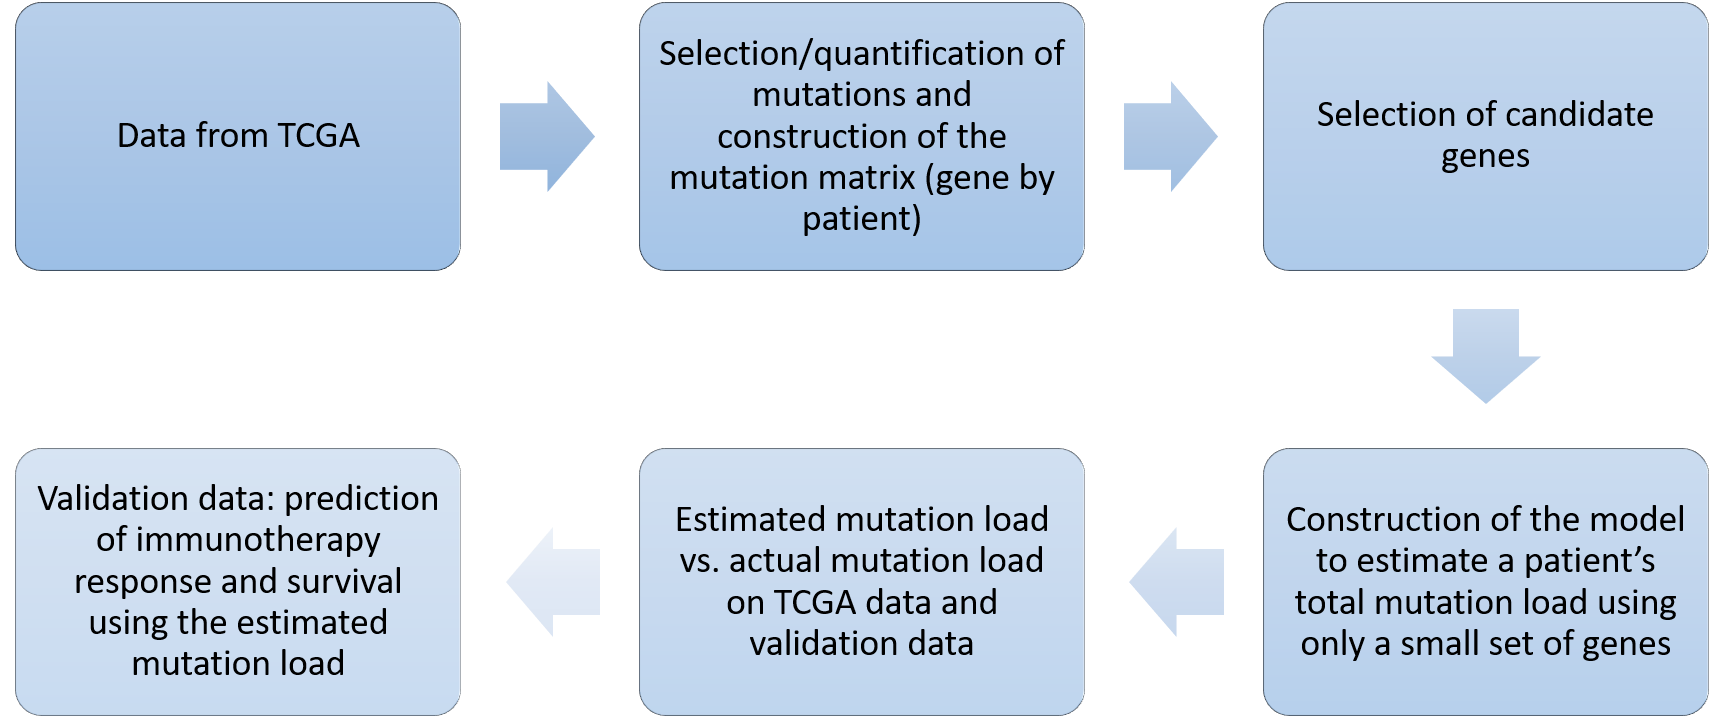

In [324]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm
from sklearn.linear_model import LassoLarsIC
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from RegscorePy.bic import bic
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [325]:
# set up the data path
DATA = Path('./data')
pd.set_option('display.max_columns', None)

# Training data

The training data were downloaded from The Cancer Genome Atlas (TCGA). We focus on the Lung Adenocarcinoma (LUAD). 

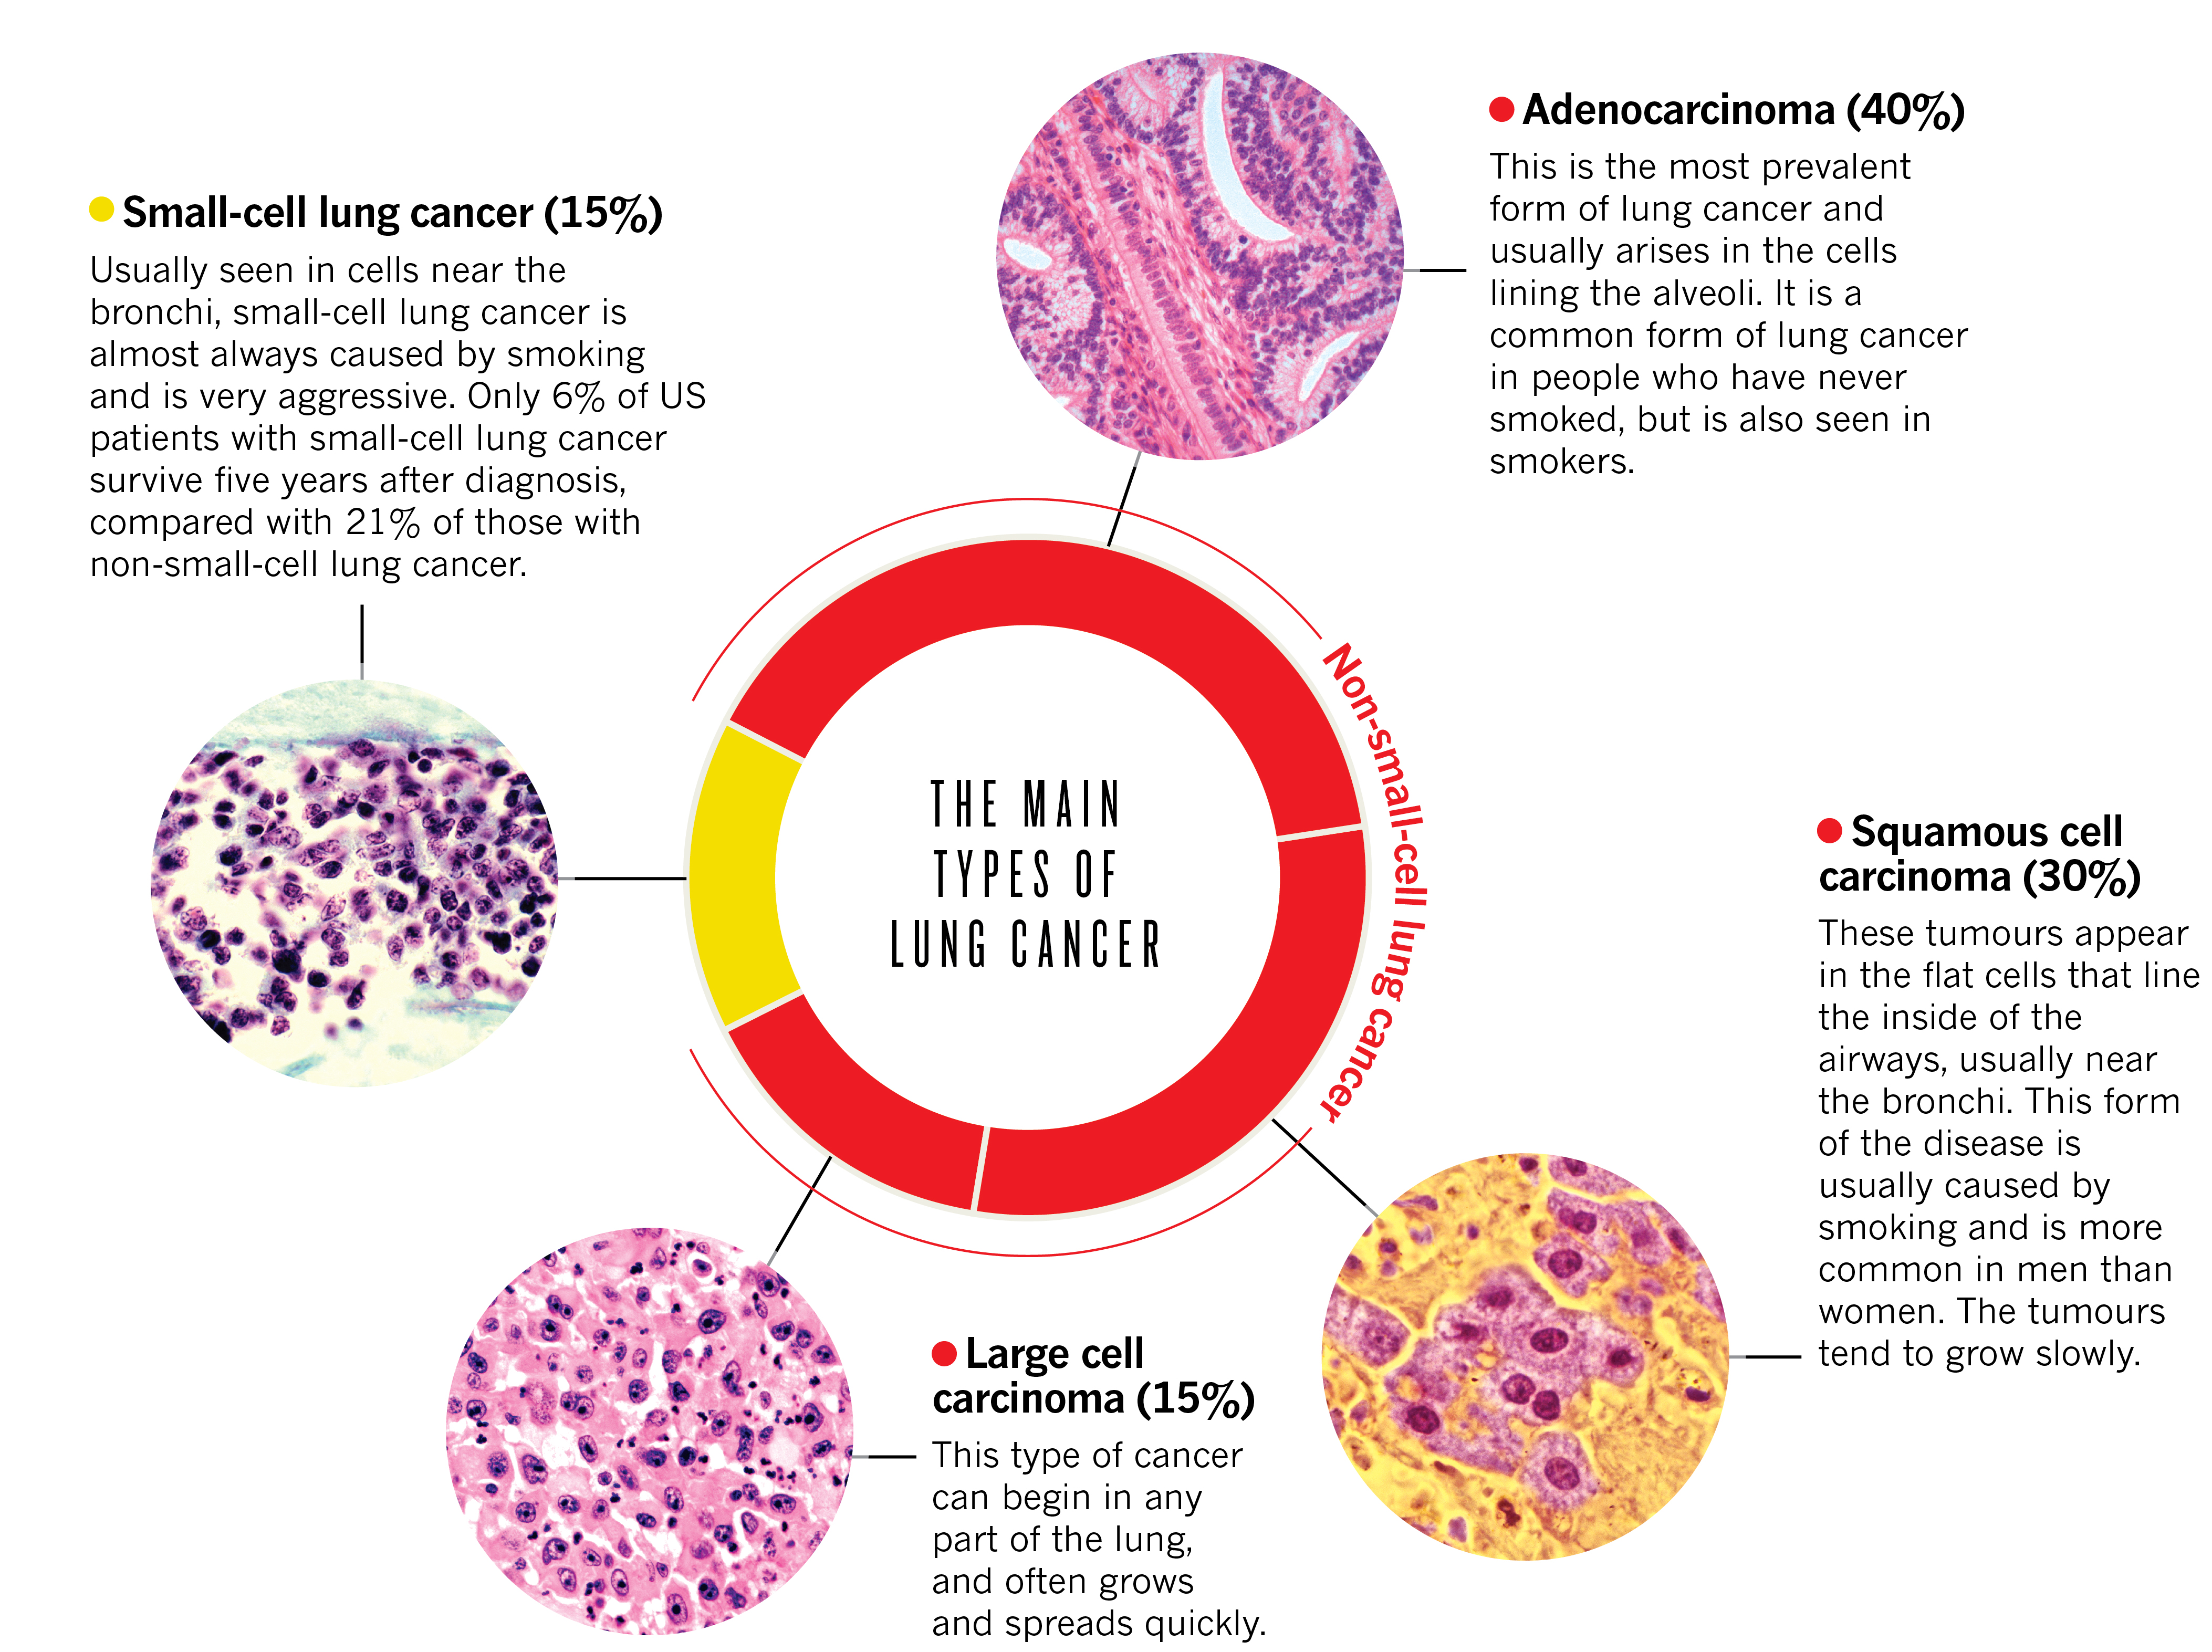

Source: http://blogs.nature.com/ofschemesandmemes/2014/09/11/the-dominant-malignancy-lung-cancer

In [326]:
tcga = pd.read_excel(DATA/'TCGA_LUAD.xlsx', header=1)
tcga.head()

Hugo_Symbol  Entrez_Gene_Id         Center  NCBI_Build Chromosome  \
0     PLEKHN1           84069  broad.mit.edu          37          1   
1      UBE2J2          118424  broad.mit.edu          37          1   
2     Unknown               0  broad.mit.edu          37          1   
3    C1orf200          644997  broad.mit.edu          37          1   
4   LOC649330          649330  broad.mit.edu          37          1   

   Start_position  End_position Strand Variant_Classification Variant_Type  \
0          905907        905907      +      Missense_Mutation          SNP   
1         1192480       1192480      +                 Silent          SNP   
2         1854885       1854885      +      Missense_Mutation          SNP   
3         9713992       9713992      +      Missense_Mutation          SNP   
4        12908093      12908093      +      Missense_Mutation          SNP   

  Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2 dbSNP_RS  \
0                A                 A                 T      NaN   
1                C                 C                 A      NaN   
2                G                 G                 C      NaN   
3                G                 G                 A      NaN   
4                C                 C                 A      NaN   

  dbSNP_Val_Status          Tumor_Sample_Barcode  \
0              NaN  TCGA-05-4249-01A-01D-1105-08   
1              NaN  TCGA-05-4249-01A-01D-1105-08   
2              NaN  TCGA-05-4249-01A-01D-1105-08   
3              NaN  TCGA-05-4249-01A-01D-1105-08   
4              NaN  TCGA-05-4249-01A-01D-1105-08   

    Matched_Norm_Sample_Barcode Match_Norm_Seq_Allele1 Match_Norm_Seq_Allele2  \
0  TCGA-05-4249-10A-01D-1105-08                      A                      A   
1  TCGA-05-4249-10A-01D-1105-08                      C                      C   
2  TCGA-05-4249-10A-01D-1105-08                      G                      G   
3  TCGA-05-4249-10A-01D-1105-08                      G                      G   
4  TCGA-05-4249-10A-01D-1105-08                      C                      C   

  Tumor_Validation_Allele1 Tumor_Validation_Allele2  \
0                        -                        -   
1                        -                        -   
2                        -                        -   
3                        -                        -   
4                        -                        -   

  Match_Norm_Validation_Allele1 Match_Norm_Validation_Allele2  \
0                             A                             A   
1                             C                             C   
2                             G                             G   
3                             G                             G   
4                             C                             C   

  Verification_Status Validation_Status Mutation_Status Sequencing_Phase  \
0             Unknown          Untested         Somatic      Unspecified   
1             Unknown          Untested         Somatic      Unspecified   
2             Unknown          Untested         Somatic      Unspecified   
3             Unknown          Untested         Somatic      Unspecified   
4             Unknown          Untested         Somatic      Unspecified   

  Sequence_Source Validation_Method  Score  BAM_file       Sequencer  \
0             WXS              none    NaN       NaN  Illumina HiSeq   
1             WXS              none    NaN       NaN  Illumina HiSeq   
2             WXS              none    NaN       NaN  Illumina HiSeq   
3             WXS              none    NaN       NaN  Illumina HiSeq   
4             WXS              none    NaN       NaN  Illumina HiSeq   

                      Tumor_Sample_UUID              Matched_Norm_Sample_UUID  \
0  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d0-e1bd-4a65-9ecf-b6bad02196d7   
1  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d0-e1bd-4a65-9ecf-b6bad02196d7   
2  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d

In [327]:
tcga.columns

Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_position', 'End_position', 'Strand', 'Variant_Classification',
       'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1',
       'Tumor_Seq_Allele2', 'dbSNP_RS', 'dbSNP_Val_Status',
       'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode',
       'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2',
       'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2',
       'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2',
       'Verification_Status', 'Validation_Status', 'Mutation_Status',
       'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score',
       'BAM_file', 'Sequencer', 'Tumor_Sample_UUID',
       'Matched_Norm_Sample_UUID', 'Genome_Change', 'Annotation_Transcript',
       'Transcript_Strand', 'Transcript_Exon', 'Transcript_Position',
       'cDNA_Change', 'Codon_Change', 'Protein_Change', 'Other_Transcripts',
       'Refseq_mRNA_Id', 'Refseq_prot_Id'

The only columns we need are **Hugo_Symbol**, **Tumor_Sample_Barcode**, **Variant_Classification**, and **Variant_Type**.

# Data - filtering and construction

## Selection of mutations

 “**Variant_Classification**”: select
 + nonsense mutation: involve a change from a normal codon to a stop codon.
 + nonstop mutation: occurs within a stop codon, which causes the continued translation of an mRNA strand. 
 + missense mutation: leads to an amino acid change.

In [328]:
tcga.Variant_Classification.unique()

array(['Missense_Mutation', 'Silent', 'Nonsense_Mutation', 'Splice_Site',
       'Translation_Start_Site', 'Nonstop_Mutation', 'Frame_Shift_Del',
       'Frame_Shift_Ins', 'In_Frame_Del', 'In_Frame_Ins'], dtype=object)

In [329]:
nonsyn = tcga[tcga['Variant_Classification'].isin([ 'Nonsense_Mutation', 'Nonstop_Mutation', 'Missense_Mutation'])]

In [330]:
nonsyn['Variant_Classification'].unique()

array(['Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation'],
      dtype=object)

"**Variant_Type**": select SNP, DNP, and TNP (polymorphysm). The mutation counts are 1, 2, and 3, respectively.

In [331]:
tcga.Variant_Type.unique()

array(['SNP', 'DNP', 'TNP', 'DEL', 'INS'], dtype=object)

In [332]:
poly = nonsyn[nonsyn['Variant_Type'].isin(['SNP', 'DNP', 'TNP'])]
poly = poly[poly.Hugo_Symbol != 'Unknown'] # remove data with no gene names
poly.Variant_Type.unique()

array(['SNP', 'DNP', 'TNP'], dtype=object)

In [333]:
poly.head()

Hugo_Symbol  Entrez_Gene_Id         Center  NCBI_Build Chromosome  \
0     PLEKHN1           84069  broad.mit.edu          37          1   
3    C1orf200          644997  broad.mit.edu          37          1   
4   LOC649330          649330  broad.mit.edu          37          1   
5       CROCC            9696  broad.mit.edu          37          1   
7      TAS1R2           80834  broad.mit.edu          37          1   

   Start_position  End_position Strand Variant_Classification Variant_Type  \
0          905907        905907      +      Missense_Mutation          SNP   
3         9713992       9713992      +      Missense_Mutation          SNP   
4        12908093      12908093      +      Missense_Mutation          SNP   
5        17257855      17257855      +      Missense_Mutation          SNP   
7        19181144      19181144      +      Missense_Mutation          SNP   

  Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2 dbSNP_RS  \
0                A                 A                 T      NaN   
3                G                 G                 A      NaN   
4                C                 C                 A      NaN   
5                C                 C                 T      NaN   
7                C                 C                 T      NaN   

  dbSNP_Val_Status          Tumor_Sample_Barcode  \
0              NaN  TCGA-05-4249-01A-01D-1105-08   
3              NaN  TCGA-05-4249-01A-01D-1105-08   
4              NaN  TCGA-05-4249-01A-01D-1105-08   
5              NaN  TCGA-05-4249-01A-01D-1105-08   
7              NaN  TCGA-05-4249-01A-01D-1105-08   

    Matched_Norm_Sample_Barcode Match_Norm_Seq_Allele1 Match_Norm_Seq_Allele2  \
0  TCGA-05-4249-10A-01D-1105-08                      A                      A   
3  TCGA-05-4249-10A-01D-1105-08                      G                      G   
4  TCGA-05-4249-10A-01D-1105-08                      C                      C   
5  TCGA-05-4249-10A-01D-1105-08                      C                      C   
7  TCGA-05-4249-10A-01D-1105-08                      C                      C   

  Tumor_Validation_Allele1 Tumor_Validation_Allele2  \
0                        -                        -   
3                        -                        -   
4                        -                        -   
5                        -                        -   
7                        -                        -   

  Match_Norm_Validation_Allele1 Match_Norm_Validation_Allele2  \
0                             A                             A   
3                             G                             G   
4                             C                             C   
5                             C                             C   
7                             C                             C   

  Verification_Status Validation_Status Mutation_Status Sequencing_Phase  \
0             Unknown          Untested         Somatic      Unspecified   
3             Unknown          Untested         Somatic      Unspecified   
4             Unknown          Untested         Somatic      Unspecified   
5             Unknown          Untested         Somatic      Unspecified   
7             Unknown          Untested         Somatic      Unspecified   

  Sequence_Source Validation_Method  Score  BAM_file       Sequencer  \
0             WXS              none    NaN       NaN  Illumina HiSeq   
3             WXS              none    NaN       NaN  Illumina HiSeq   
4             WXS              none    NaN       NaN  Illumina HiSeq   
5             WXS              none    NaN       NaN  Illumina HiSeq   
7             WXS              none    NaN       NaN  Illumina HiSeq   

                      Tumor_Sample_UUID              Matched_Norm_Sample_UUID  \
0  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d0-e1bd-4a65-9ecf-b6bad02196d7   
3  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d0-e1bd-4a65-9ecf-b6bad02196d7   
4  8be717b5-5b65-4631-a175-1f4c063d447e  5d48c4d

## Construction of the mutation matrix

Gene by patient

In [334]:
# create an empty mutation matrix
col = poly['Tumor_Sample_Barcode'].unique()
idx = poly['Hugo_Symbol'].unique()
mutmtx = pd.DataFrame(np.zeros([len(idx), len(col)]), columns=col, index=idx)

# fill in the mutation matrix
vt = {'SNP': 1, 'DNP': 2, 'TNP': 3}
for _, row in poly.iterrows():
    mutmtx.loc[row.Hugo_Symbol, row.Tumor_Sample_Barcode] += vt[row.Variant_Type]
    
# remove genes that they do not exist in all datasets
mutmtx = mutmtx.drop(['ZNF521', 'KMT2C', 'ADGRG4', 'COL6A3', 'ERICH3', 'NOTCH4', 'RIMS2', 'MKI67', 'DNAH8', 'MYH7'])

In [335]:
mutmtx.shape

(13516, 230)

In [336]:
mutmtx.head()

TCGA-05-4249-01A-01D-1105-08  TCGA-05-4382-01A-01D-1265-08  \
PLEKHN1                             1.0                           0.0   
C1orf200                            1.0                           0.0   
LOC649330                           1.0                           0.0   
CROCC                               1.0                           0.0   
TAS1R2                              1.0                           0.0   

           TCGA-05-4384-01A-01D-1753-08  TCGA-05-4389-01A-01D-1265-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4390-01A-02D-1753-08  TCGA-05-4395-01A-01D-1265-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           1.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4396-01A-21D-1855-08  TCGA-05-4398-01A-01D-1265-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4402-01A-01D-1265-08  TCGA-05-4403-01A-01D-1265-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4405-01A-21D-1855-08  TCGA-05-4410-01A-21D-1855-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              1.0                           0.0   

           TCGA-05-4415-01A-22D-1855-08  TCGA-05-4417-01A-22D-1855-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           1.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4418-01A-01D-1265-08  TCGA-05-4420-01A-01D-1265-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4422-01A-01D-1265-08  TCGA-05-4424-01A-22D-1855-08  \
PLEKHN1                             0.0                           0.0   
C1orf200                            0.0                           0.0   
LOC649330                           0.0                           0.0   
CROCC                               0.0                           0.0   
TAS1R2                              0.0                           0.0   

           TCGA-05-4425-01A-01D-1753-08  TCGA-05-4426-01A-01

In [337]:
# mutmtx.to_csv(DATA/'mutmtx.csv')

In [338]:
# mutmtx = pd.read_csv(DATA/'mutmtx.csv', index_col=0)
# # remove genes that they do not exist in all datasets
# mutmtx = mutmtx.drop(['ZNF521', 'KMT2C', 'ADGRG4', 'COL6A3', 'ERICH3', 'NOTCH4', 'RIMS2', 'MKI67', 'DNAH8', 'MYH7'])
# mutmtx.head()

# Candidate gene selection (CGS)

1)	Mutation frequency ≥ 10%,

2)	Coding DNA sequence (CDS) length ≤ 15,000, 

3)	P-value < 0.05 in rank-sum test.

Construct a table called `cgs` with each row being a gene and 3 columns: Mut_Freq, CDS, P_Value.

### Mutation frequency

The mutation frequency for a gene is the number of mutants divided by the total number of copies of that gene within a population.

In [339]:
# get mutation frequency
cgs = pd.DataFrame(index=mutmtx.index, columns=['Mut_Freq'])
cgs.Mut_Freq = mutmtx.sum(axis=1)/mutmtx.shape[1]
cgs

Mut_Freq
PLEKHN1    0.004348
C1orf200   0.004348
LOC649330  0.021739
CROCC      0.030435
TAS1R2     0.034783
...             ...
BUD31      0.004348
GALNTL5    0.004348
NR0B1      0.008696
PGK1       0.004348
CETN2      0.004348

[13516 rows x 1 columns]

### DNA sequence length

The information of the DNA-sequence lengths were obtained from the Ensembl BioMart database.

We focus on shorter DNA sequences to reduce experimental cost. 

In [340]:
# get DNA sequence length (CDS)
cds_len = pd.read_excel(DATA/'CDS_Length.xlsx')
# remove duplicate rows
cds_len.drop_duplicates(subset='GeneName', keep='first', inplace=True)
# set 'GeneName' column as index
cds_len.set_index('GeneName', inplace=True)
cds_len

EnsemblGeneID CDS length EntrezGeneID
GeneName                                               
TSPAN6          ENSG00000000003        738         7105
TNMD            ENSG00000000005        954        64102
DPM1            ENSG00000000419        886         8813
SCYL3           ENSG00000000457       2229        57147
C1orf112        ENSG00000000460       2562        55732
...                         ...        ...          ...
CTD-2331H12.9   ENSG00000283695          -            -
RP11-122G18.12  ENSG00000283696          -            -
RP5-937E21.8    ENSG00000283697       1002    101928917
RP11-606M12.1   ENSG00000283698          -            -
MIR4481         ENSG00000283699          -    100616320

[56641 rows x 3 columns]

In [341]:
# trim cds_len to contain only the genes in cgs
cds_len_trim = cds_len[cds_len.index.isin(cgs.index)]
cds_len_trim

EnsemblGeneID CDS length EntrezGeneID
GeneName                                          
TNMD       ENSG00000000005        954        64102
DPM1       ENSG00000000419        886         8813
SCYL3      ENSG00000000457       2229        57147
C1orf112   ENSG00000000460       2562        55732
FGR        ENSG00000000938       1590         2268
...                    ...        ...          ...
OR1B1      ENSG00000280094        957       347169
PCDH20     ENSG00000280165       2856        64881
OR1S1      ENSG00000280204        978       219959
HSP90AB4P  ENSG00000282100          -            -
ADORA3     ENSG00000282608        957          140

[12525 rows x 3 columns]

In [342]:
# sort cds_len_trim indexes (GeneName) to the same order as cgs
cds_len_sort = cds_len_trim.reindex(cgs.index)
cds_len_sort

EnsemblGeneID CDS length EntrezGeneID
PLEKHN1    ENSG00000187583       1992        84069
C1orf200               NaN        NaN          NaN
LOC649330              NaN        NaN          NaN
CROCC      ENSG00000058453       6054         9696
TAS1R2     ENSG00000179002       2520        80834
...                    ...        ...          ...
BUD31      ENSG00000106245        435         8896
GALNTL5    ENSG00000106648       1332       168391
NR0B1      ENSG00000169297       1413          190
PGK1       ENSG00000102144       1254         5230
CETN2      ENSG00000147400        519         1069

[13516 rows x 3 columns]

In [343]:
# finally, add 'CDS' column to cgs table
cgs['CDS'] = cds_len_sort['CDS length']
cgs

Mut_Freq   CDS
PLEKHN1    0.004348  1992
C1orf200   0.004348   NaN
LOC649330  0.021739   NaN
CROCC      0.030435  6054
TAS1R2     0.034783  2520
...             ...   ...
BUD31      0.004348   435
GALNTL5    0.004348  1332
NR0B1      0.008696  1413
PGK1       0.004348  1254
CETN2      0.004348   519

[13516 rows x 2 columns]

### Rank-sum test

For each gene, one vector contains the mutation load of patients that have a mutation in that gene; the other vector contains the mutation load of patients that do not have a mutation in that gene.

In [344]:
# first, calculate the mutation load for each patient
mut_load = mutmtx.sum(axis=0)
mut_load

TCGA-05-4249-01A-01D-1105-08     284.0
TCGA-05-4382-01A-01D-1265-08    1266.0
TCGA-05-4384-01A-01D-1753-08     119.0
TCGA-05-4389-01A-01D-1265-08     210.0
TCGA-05-4390-01A-02D-1753-08     478.0
                                 ...  
TCGA-97-7554-01A-11D-2036-08     377.0
TCGA-97-7937-01A-11D-2167-08     389.0
TCGA-97-7938-01A-11D-2167-08     325.0
TCGA-97-7941-01A-11D-2184-08      75.0
TCGA-99-7458-01A-11D-2036-08     391.0
Length: 230, dtype: float64

In [345]:
# loop through each gene to get muted (pov) and not muted (neg)
cgs['P_Value'] = 1   #add a column called P_Value
for index, row in mutmtx.iterrows():
    pov = np.array(row>0)
    neg = np.array(row==0) 
    # ranksums returns two values: the first is the statistics; the second is the p value.
    cgs.loc[index, 'P_Value'] = ranksums(mut_load[pov], mut_load[neg])[1]
#     cgs.loc[index, 'P_Value'] = multipletests(ranksums(mut_load[pov], mut_load[neg])[1], method='holm-sidak')[1] 
cgs

Mut_Freq   CDS   P_Value
PLEKHN1    0.004348  1992  0.378266
C1orf200   0.004348   NaN  0.378266
LOC649330  0.021739   NaN  0.065545
CROCC      0.030435  6054  0.012802
TAS1R2     0.034783  2520  0.007017
...             ...   ...       ...
BUD31      0.004348   435  0.240077
GALNTL5    0.004348  1332  0.240077
NR0B1      0.008696  1413  0.240077
PGK1       0.004348  1254  0.240077
CETN2      0.004348   519  0.240077

[13516 rows x 3 columns]

In [346]:
# CDS is missing for some genes, which show '-'
cgs.CDS[cgs.CDS=='-'] = np.nan
# remove genes with NaN from cgs
cgs_nona = cgs.dropna()

In [347]:
# get selected genes based on the three criteria
selected = cgs_nona.loc[(cgs_nona.Mut_Freq >= 0.1) & 
                        (cgs_nona.CDS.astype(int) <= 15000) & 
                        (cgs_nona.P_Value < 0.05/mutmtx.shape[0])]  # Bonferroni

In [348]:
selected.head()

Mut_Freq    CDS       P_Value
FLG     0.386957  12186  3.142219e-13
TNR     0.165217   4077  3.556803e-06
RYR2    0.539130  14904  2.848528e-12
NALCN   0.165217   5217  1.480126e-07
ZNF208  0.108696   3843  1.143140e-07

In [349]:
np.sort(selected.index)

array(['ADAMTS12', 'ANK2', 'APOB', 'ASPM', 'ASTN1', 'ASXL3', 'CACNA1E',
       'CDH10', 'CDH12', 'CNTNAP2', 'CNTNAP5', 'COL11A1', 'COL3A1',
       'CPS1', 'CSMD2', 'CSMD3', 'DNAH3', 'DNAH9', 'DOCK2', 'FAM135B',
       'FAM47C', 'FAT4', 'FBN2', 'FLG', 'FLG2', 'GPR158', 'HGF', 'HRNR',
       'LAMA2', 'LRP1B', 'LRP2', 'MUC17', 'MXRA5', 'MYH1', 'NALCN',
       'NAV3', 'NRXN1', 'PAPPA2', 'PCDH11X', 'PCDH15', 'PKHD1', 'PKHD1L1',
       'PLCB1', 'PRDM9', 'PRUNE2', 'PTPRD', 'PXDNL', 'RELN', 'RP1L1',
       'RYR2', 'RYR3', 'SI', 'SORCS1', 'SORCS3', 'SVEP1', 'TAF1L', 'TNR',
       'TPTE', 'TSHZ2', 'XIRP2', 'ZFHX4', 'ZNF208', 'ZNF536', 'ZNF804A',
       'ZNF831'], dtype=object)

In [350]:
len(selected.index)

65

# Construction of the mutation-load estimation model

$y = c + \sum_{i=1}^{n}a_i * x_i$

This is a combination problem, which is computationally expensive.

1)	Least squares parameter estimation: 

2)	Bayesian information criterion (BIC):



## Recursive feature elimination (RFE) with BIC
Recursive feature elimination (RFE) selects features by recursively considering smaller and smaller sets of features. 
+ The estimator is trained on the initial set of features and the importance of each feature is obtained. 
+ The least important features are pruned from current set of features. 
+ That procedure is recursively repeated on the pruned set until the desired number of features to select is reached.

We are going to use Baysian information criterion (BIC) to determine the best number of features to select.

BIC $= k\ln(n)-2\ln({\widehat {L}})$
where

+ $\hat L =$ the maximized value of the likelihood function of the model;
+ $x =$ the observed data;
+ $n =$ the number of data points in $x$;
+ $k =$ the number of parameters estimated by the model.

In [351]:
x = mutmtx[mutmtx.index.isin(selected.index)].transpose() # each column should be a feature
y = mut_load.transpose()

In [352]:
estimator = LinearRegression()
score = np.zeros(selected.shape[0])

for i in range(selected.shape[0]):
    selector = RFE(estimator, n_features_to_select=i+1, step=1)
    selector = selector.fit(x, y)
    y_pred = selector.predict(x)
    score[i] = bic(y, y_pred, i+1)

In [353]:
estimator = LinearRegression()
selector = RFE(estimator, np.argmin(score), step=1) # select the model with the smallest BIC score

## Apply the model to the TCGA data

1) Estimate the mutation load for all patients;

2) Calculate the $R^2$ (coefficient of determination is the proportion of the variation in the dependent variable that is predictable from the independent variable.) between the estimated and actual mutation load.

In [354]:
selector = selector.fit(x, y)
y_pred = selector.predict(x)

r2 = round(r2_score(y, y_pred), 4)
r2

0.9394

(0.0, 1400.0, 0.0, 1400.0)

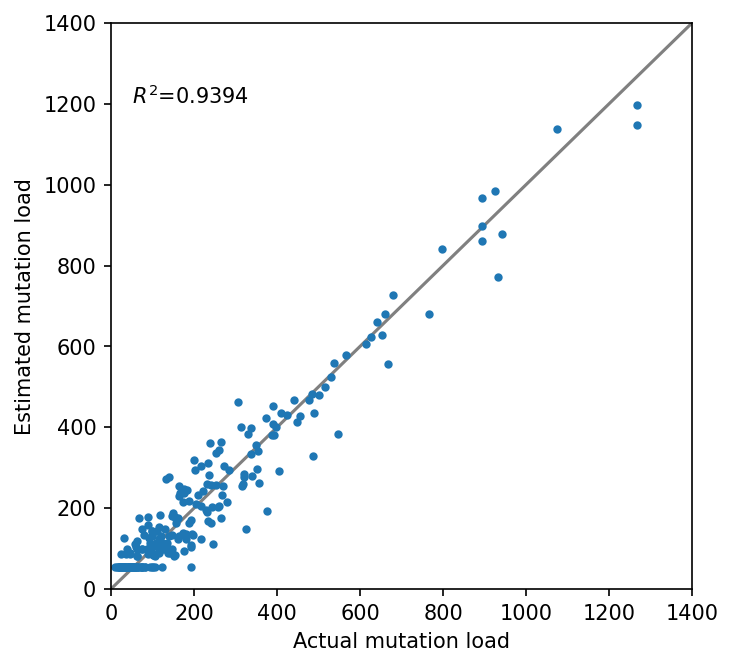

In [355]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.plot([0, 1400], [0, 1400], linestyle='-', color='gray')
plt.plot(y, y_pred, '.')
ax.text(50, 1200, f"$R^2$={r2}")
plt.xlabel('Actual mutation load')
plt.ylabel('Estimated mutation load')
plt.axis([0, 1400, 0, 1400])

## Genes and the corresponding parameters

In [356]:
gene_idx = selector.get_support()
x_r = x[selected.index[gene_idx]]

In [357]:
estimator_r = LinearRegression()
estimator_r.fit(x_r, y)

LinearRegression()

In [358]:
model_gene = []
print("Genes and parameters used in mutation load estimation model")
for i in range(len(selected.index[gene_idx])):
    model_gene.append(selected.index[gene_idx][i])
    print(selected.index[gene_idx][i], ":", estimator_r.coef_[i])
print("Constant term:", estimator_r.intercept_)

Genes and parameters used in mutation load estimation model
FLG : 44.363198356295136
NALCN : 60.85291797963888
APOB : 28.28564465514989
ADAMTS12 : 34.548209196604354
LAMA2 : 72.89017349339964
COL11A1 : 34.24283137471805
HRNR : 31.27055787388602
ASTN1 : 31.93544921056017
ASPM : 49.275504988044474
GPR158 : 88.96219364123245
SORCS1 : 30.12685007444187
NAV3 : 33.23412964636816
CPS1 : 50.189389453195496
TSHZ2 : 44.018522000724595
CDH10 : 45.898756761970176
PXDNL : 57.12064198017785
SVEP1 : 34.201096128535355
MXRA5 : 45.10348290778347
FAM47C : 60.954437658693195
TAF1L : 40.85491097240484
TPTE : 70.01598731967113
CSMD2 : 99.59276257962136
SORCS3 : 40.94188890927224
CNTNAP2 : 27.198310422996446
PRUNE2 : -33.0664591589434
Constant term: 53.99768884298908


In [359]:
print("Number of genes used in the model:", len(model_gene))

Number of genes used in the model: 25


# Performance evaluation on the validation data

## Imielinski et al.

In [360]:
val183 = pd.read_csv(DATA/'ValidationDataN183.txt',sep="\t", comment='#', low_memory=False)
val183.head()

Hugo_Symbol  Entrez_Gene_Id         Center  NCBI_Build Chromosome  \
0       NT5C2           22978  broad.mit.edu          37         10   
1       OR8B3          390271  broad.mit.edu          37         11   
2      CCDC91           55297  broad.mit.edu          37         12   
3       PCBP2            5094  broad.mit.edu          37         12   
4      TUBA3C            7278  broad.mit.edu          37         13   

   Start_position  End_position Strand Variant_Classification Variant_Type  \
0       104849434     104849434      +      Missense_Mutation          SNP   
1       124266372     124266372      +      Missense_Mutation          SNP   
2        28412312      28412312      +      Missense_Mutation          SNP   
3        53849767      53849767      +                 Silent          SNP   
4        19752452      19752452      +                 Silent          SNP   

  Reference_Allele Tumor_Seq_Allele1 Tumor_Seq_Allele2     dbSNP_RS  \
0                C                 T                 T          NaN   
1                C                 A                 A          NaN   
2                G                 C                 C          NaN   
3                C                 T                 T          NaN   
4                G                 A                 A  rs114178008   

  dbSNP_Val_Status Tumor_Sample_Barcode Matched_Norm_Sample_Barcode  \
0              NaN     LUAD-5O6B5-Tumor           LUAD-5O6B5-Normal   
1              NaN     LUAD-5O6B5-Tumor           LUAD-5O6B5-Normal   
2              NaN     LUAD-5O6B5-Tumor           LUAD-5O6B5-Normal   
3              NaN     LUAD-5O6B5-Tumor           LUAD-5O6B5-Normal   
4              NaN     LUAD-5O6B5-Tumor           LUAD-5O6B5-Normal   

   Match_Norm_Seq_Allele1  Match_Norm_Seq_Allele2  Tumor_Validation_Allele1  \
0                     NaN                     NaN                       NaN   
1                     NaN                     NaN                       NaN   
2                     NaN                     NaN                       NaN   
3                     NaN                     NaN                       NaN   
4                     NaN                     NaN                       NaN   

   Tumor_Validation_Allele2  Match_Norm_Validation_Allele1  \
0                       NaN                            NaN   
1                       NaN                            NaN   
2                       NaN                            NaN   
3                       NaN                            NaN   
4                       NaN                            NaN   

   Match_Norm_Validation_Allele2  Verification_Status  Validation_Status  \
0                            NaN                  NaN                NaN   
1                            NaN                  NaN                NaN   
2                            NaN                  NaN                NaN   
3                            NaN                  NaN                NaN   
4                            NaN                  NaN                NaN   

  Mutation_Status Sequencing_Phase Sequence_Source  Validation_Method  Score  \
0         Unknown      Unspecified     Unspecified                NaN    NaN   
1         Unknown      Unspecified     Unspecified                NaN    NaN   
2         Unknown      Unspecified     Unspecified                NaN    NaN   
3         Unknown      Unspecified     Unspecified                NaN    NaN   
4         Unknown      Unspecified     Unspecified                NaN    NaN   

   BAM_file    Sequencer   alt    ref cDNA_Change Refseq_mRNA_Id  \
0       NaN  Unspecified   9.0  121.0   c.1681G>A      NM_012229   
1       NaN  Unspecified  17.0  204.0    c.876G>T   NM_001005467   
2       NaN  Unspecified   5.0  141.0     c.46G>C      NM_018318   
3       NaN  Unspecified  79.0  603.0    c.225C>T   NM_001128911   
4       NaN  Unspecified  12.0  222.0    c.309C>T      NM_006001   

  Refseq_prot_Id Protein_Change  
0      NP_036361       

In [361]:
val183.Variant_Type.unique()

array(['SNP', 'DNP', 'TNP', 'DEL', 'INS'], dtype=object)

In [362]:
val183_nonsyn = val183[val183['Variant_Classification'].isin([ 'Nonsense_Mutation', 'Nonstop_Mutation', 'Missense_Mutation'])]
val183_poly = val183_nonsyn[val183_nonsyn['Variant_Type'].isin(['SNP', 'DNP', 'TNP'])]

In [363]:
# create an empty mutation matrix
val183_col = val183_poly['Tumor_Sample_Barcode'].unique()
val183_idx = val183_poly['Hugo_Symbol'].unique()
val183_mutmtx = pd.DataFrame(np.zeros([len(val183_idx), len(val183_col)]), 
                             columns=val183_col, index=val183_idx)

# fill in the mutation matrix
vt = {'SNP': 1, 'DNP': 2, 'TNP': 3}
for _, row in val183_poly.iterrows():
    val183_mutmtx.loc[row.Hugo_Symbol, row.Tumor_Sample_Barcode] += vt[row.Variant_Type]

In [364]:
val183_mutmtx.head()

LUAD-5O6B5-Tumor  LUAD-B00416-Tumor  LUAD-B00523-Tumor  \
NT5C2                   1.0                1.0                0.0   
OR8B3                   1.0                0.0                0.0   
CCDC91                  1.0                0.0                0.0   
ARHGAP11A               1.0                0.0                0.0   
TRPM7                   1.0                0.0                0.0   

           LUAD-B00859-Tumor  LUAD-B00915-Tumor  LUAD-B01102-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-B01145-Tumor  LUAD-B01169-Tumor  LUAD-B01811-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-B02077-Tumor  LUAD-B02216-Tumor  LUAD-B02477-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-B02515-Tumor  LUAD-B02594-Tumor  LUAD-D01382-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-D01603-Tumor  LUAD-D01751-Tumor  LUAD-D02185-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-E00163-Tumor  LUAD-F00018-Tumor  LUAD-F00057-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-F00089-Tumor  LUAD-F00134-Tumor  LUAD-F00257-Tumor  \
NT5C2                    0.0                0.0                0.0   
OR8B3                    0.0                0.0                0.0   
CCDC91                   0.0                0.0                0.0   
ARHGAP11A                0.0                0.0                0.0   
TRPM7                    0.0                0.0                0.0   

           LUAD-F00365-Tumor  LUAD-F00368-Tumor  LUAD-GU4I3-Tumor  \
NT5C2                    0.0                0.0               0.0   
OR8B3                    0.0                0.0               0.0   
CCDC91                   0.0                0.0               0.0   
ARHGAP11A                0.0                0.0               0.0   
TRPM7                    0.0                0.0               0.0   

           LUAD-LC15C-Tumor  LUAD-LIP77-Tumor  LUAD-QJN9L-Tumor  \
NT5C2                   0.0               0.0               0.0   
OR8B3                   0.0               0.0               0.0   
CCDC91                  0.0      

In [365]:
val183_mutmtx.shape

(13285, 181)

## Rizvi et al. 

In [366]:
# Mutation data
val34 = pd.read_excel(DATA/'ValidationDataN34_mut.xlsx', header=6)
val34.head()

Sample   Gene Chr  Position Ref Alt  Ncov  Tcov  Naf       Taf
0  AL4602  ACAP3   1   1229796   G   A    11     9  0.0  0.222222
1  AL4602   VWA1   1   1374587   C   A    22    12  0.0  0.166700
2  AL4602   MIB2   1   1560749   A   G    18     8  0.0  0.250000
3  AL4602   H6PD   1   9324270   C   A    32     9  0.0  0.222222
4  AL4602  CASZ1   1  10699817   C   T    10    10  0.0  0.200000

In [367]:
# Immunotherapy response
xlsl = pd.read_excel(DATA/'ValidationDataN34_Immuno_Response.xlsx', header=1, index_col=1, skipfooter=13)
xlsl.head()

# Cohort (Discovery, Validation)  Histology  Age (years) Sex  \
Study ID                                                                 
SA9755    1                          Valid  NSCLC NOS           63   F   
HE3202    2                           Disc      Adeno           63   F   
TU0428    3                           Disc      Adeno           66   M   
Y2087     4                          Valid      Adeno           68   F   
RI1933    6                           Disc      Adeno           60   F   

            Smoke  Pack-years     PD-L1  Priors  Dose (mg/kg)  Sched  \
Study ID                                                               
SA9755     Former        36.0      Weak       1            10      3   
HE3202     Former        58.0    Strong       3            10      3   
TU0428    Current        48.0  Negative       0            10      3   
Y2087       Never         0.0      Weak       5            10      3   
RI1933     Former        21.0    Strong       1            10      3   

          PFS (mos)  Event Resp Durable Clinical Benefit  Nonsyn Smok-Sig  \
Study ID                                                                    
SA9755     8.366667      0   PR                      DCB    1192       TH   
HE3202    14.666667      0   PR                      DCB     746       TH   
TU0428     2.066667      1  POD                      NDB     626       TH   
Y2087      8.333333      1   SD                      DCB     507       TL   
RI1933    16.600000      0   PR                      DCB     473       TH   

          Neoant  Total exonic  
Study ID                        
SA9755       576          1732  
HE3202       610          1011  
TU0428       446           992  
Y2087        358           914  
RI1933       228           622

In [368]:
xlsl['Durable Clinical Benefit'].unique()

array(['DCB', 'NDB', 'NR'], dtype=object)

In [369]:
# DCB: Durable Clinical Benefit; NDB: No Durable Benefit; NR: Not Reached 6 months follow-up
therapy = xlsl[xlsl['Durable Clinical Benefit'].isin(['DCB', 'NDB'])]
therapy = therapy[therapy.index.isin(val34.Sample.unique())]
therapy.shape

(30, 19)

In [370]:
# go back to remove patients without immuno-response data out of mutation data
val34_valid = val34[val34.Sample.isin(therapy.index)]

In [371]:
# create an empty mutation matrix
val34_col = val34_valid['Sample'].unique()
val34_idx = val34_valid['Gene'].unique()
val34_mutmtx = pd.DataFrame(np.zeros([len(val34_idx), len(val34_col)]), 
                             columns=val34_col, index=val34_idx)

# fill in the mutation matrix
for _, row in val34_valid.iterrows():
    val34_mutmtx.loc[row.Gene, row.Sample] += 1

In [372]:
val34_mutmtx.head()

AL4602  AU5884  BL3403  CA9903  DI6359  DM123062  GR0134  GR4788  \
ACAP3     1.0     0.0     0.0     0.0     0.0       0.0     0.0     0.0   
VWA1      1.0     0.0     0.0     0.0     0.0       0.0     0.0     0.0   
MIB2      1.0     0.0     0.0     0.0     0.0       0.0     0.0     0.0   
H6PD      1.0     0.0     0.0     0.0     0.0       0.0     0.0     0.0   
CASZ1     1.0     0.0     0.0     0.0     0.0       0.0     0.0     0.0   

       HE3202  JB112852  KA3947  LO3793  LO5004  M4945  MA7027  NI9507  \
ACAP3     0.0       0.0     0.0     0.0     0.0    0.0     0.0     0.0   
VWA1      0.0       0.0     0.0     0.0     0.0    1.0     0.0     0.0   
MIB2      0.0       0.0     0.0     0.0     0.0    0.0     0.0     0.0   
H6PD      0.0       0.0     0.0     0.0     0.0    0.0     0.0     0.0   
CASZ1     0.0       0.0     0.0     0.0     0.0    0.0     0.0     0.0   

       RH090935  RI1933  RO3338  SA9755  SB010944  SC0899  SC6470  SR070761  \
ACAP3       0.0     0.0     0.0     0.0       0.0     0.0     0.0       0.0   
VWA1        0.0     0.0     0.0     1.0       0.0     0.0     0.0       0.0   
MIB2        0.0     0.0     0.0     0.0       0.0     0.0     0.0       0.0   
H6PD        0.0     0.0     0.0     0.0       0.0     0.0     0.0       0.0   
CASZ1       0.0     0.0     0.0     0.0       0.0     0.0     0.0       0.0   

       TU0428  VA1330  VA7859  WA7899  Y2087  ZA6505  
ACAP3     0.0     0.0     0.0     0.0    1.0     0.0  
VWA1      0.0     0.0     0.0     0.0    0.0     0.0  
MIB2      0.0     0.0     0.0     0.0    0.0     0.0  
H6PD      0.0     0.0     0.0     0.0    0.0     0.0  
CASZ1     0.0     0.0     0.0     0.0    1.0     0.0

In [373]:
val34_mutmtx.shape

(5203, 30)

## Prepare validation data for prediction

In [374]:
# make sure the x data for val183 and val34 have the same orders of features (genes) as x_r
val183_model = val183_mutmtx[val183_mutmtx.index.isin(model_gene)]
val183_model = val183_model.reindex(x_r.columns)
val183_model = val183_model.transpose()
val183_model.head()

FLG  NALCN  APOB  ADAMTS12  LAMA2  COL11A1  HRNR  ASTN1  \
LUAD-5O6B5-Tumor   0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   
LUAD-B00416-Tumor  1.0    1.0   0.0       1.0    0.0      0.0   2.0    0.0   
LUAD-B00523-Tumor  0.0    0.0   1.0       0.0    0.0      1.0   0.0    2.0   
LUAD-B00859-Tumor  0.0    2.0   2.0       0.0    2.0      0.0   1.0    1.0   
LUAD-B00915-Tumor  1.0    0.0   0.0       2.0    0.0      1.0   0.0    0.0   

                   ASPM  GPR158  SORCS1  NAV3  CPS1  TSHZ2  CDH10  PXDNL  \
LUAD-5O6B5-Tumor    0.0     0.0     0.0   0.0   0.0    0.0    0.0    0.0   
LUAD-B00416-Tumor   0.0     0.0     1.0   0.0   0.0    0.0    1.0    0.0   
LUAD-B00523-Tumor   0.0     0.0     0.0   2.0   0.0    0.0    0.0    1.0   
LUAD-B00859-Tumor   0.0     0.0     1.0   0.0   0.0    0.0    0.0    0.0   
LUAD-B00915-Tumor   0.0     0.0     0.0   0.0   0.0    0.0    0.0    3.0   

                   SVEP1  MXRA5  FAM47C  TAF1L  TPTE  CSMD2  SORCS3  CNTNAP2  \
LUAD-5O6B5-Tumor     0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
LUAD-B00416-Tumor    1.0    0.0     1.0    1.0   0.0    0.0     1.0      0.0   
LUAD-B00523-Tumor    0.0    0.0     0.0    0.0   0.0    0.0     1.0      0.0   
LUAD-B00859-Tumor    0.0    0.0     0.0    0.0   1.0    1.0     0.0      0.0   
LUAD-B00915-Tumor    1.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   

                   PRUNE2  
LUAD-5O6B5-Tumor      0.0  
LUAD-B00416-Tumor     0.0  
LUAD-B00523-Tumor     0.0  
LUAD-B00859-Tumor     0.0  
LUAD-B00915-Tumor     0.0

In [375]:
val34_model = val34_mutmtx[val34_mutmtx.index.isin(model_gene)]
val34_model = val34_model.reindex(x_r.columns)
val34_model = val34_model.transpose()
val34_model.head()

FLG  NALCN  APOB  ADAMTS12  LAMA2  COL11A1  HRNR  ASTN1  ASPM  GPR158  \
AL4602  0.0    0.0   0.0       0.0    0.0      0.0   1.0    0.0   0.0     0.0   
AU5884  0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   0.0     0.0   
BL3403  0.0    0.0   0.0       0.0    0.0      0.0   1.0    0.0   0.0     0.0   
CA9903  0.0    0.0   1.0       0.0    0.0      1.0   1.0    0.0   1.0     0.0   
DI6359  0.0    0.0   1.0       0.0    0.0      0.0   0.0    0.0   0.0     0.0   

        SORCS1  NAV3  CPS1  TSHZ2  CDH10  PXDNL  SVEP1  MXRA5  FAM47C  TAF1L  \
AL4602     0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
AU5884     0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
BL3403     0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
CA9903     0.0   0.0   0.0    1.0    0.0    0.0    0.0    0.0     0.0    0.0   
DI6359     0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   

        TPTE  CSMD2  SORCS3  CNTNAP2  PRUNE2  
AL4602   0.0    0.0     0.0      0.0     0.0  
AU5884   0.0    0.0     0.0      0.0     0.0  
BL3403   0.0    0.0     0.0      0.0     0.0  
CA9903   0.0    0.0     0.0      0.0     0.0  
DI6359   0.0    0.0     0.0      0.0     0.0

In [376]:
# calculate the mutation load
val183_mut_load = val183_mutmtx.sum(axis=0)
val183_mut_load

LUAD-5O6B5-Tumor       31.0
LUAD-B00416-Tumor     746.0
LUAD-B00523-Tumor     409.0
LUAD-B00859-Tumor     272.0
LUAD-B00915-Tumor     425.0
                      ...  
LUAD-U6SJ7-Tumor      166.0
LU-A08-43-Tumor        54.0
LUAD-2GUGK-Tumor      231.0
LUAD-5V8LT-Tumor     1668.0
LUAD-E01317-Tumor     215.0
Length: 181, dtype: float64

In [377]:
# calculate the mutation load
val34_mut_load = val34_mutmtx.sum(axis=0)
val34_mut_load[:10]

AL4602      244.0
AU5884       34.0
BL3403      148.0
CA9903      324.0
DI6359      228.0
DM123062    134.0
GR0134       56.0
GR4788      170.0
HE3202      746.0
JB112852    190.0
dtype: float64

## Predict the mutation load on concatenated validation data

In [378]:
# concatenate the matrix with model genes and patients
concat_model = pd.concat([val183_model, val34_model])
concat_model

FLG  NALCN  APOB  ADAMTS12  LAMA2  COL11A1  HRNR  ASTN1  \
LUAD-5O6B5-Tumor   0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   
LUAD-B00416-Tumor  1.0    1.0   0.0       1.0    0.0      0.0   2.0    0.0   
LUAD-B00523-Tumor  0.0    0.0   1.0       0.0    0.0      1.0   0.0    2.0   
LUAD-B00859-Tumor  0.0    2.0   2.0       0.0    2.0      0.0   1.0    1.0   
LUAD-B00915-Tumor  1.0    0.0   0.0       2.0    0.0      1.0   0.0    0.0   
...                ...    ...   ...       ...    ...      ...   ...    ...   
VA1330             0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   
VA7859             0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   
WA7899             0.0    0.0   0.0       0.0    0.0      0.0   0.0    0.0   
Y2087              0.0    0.0   0.0       0.0    0.0      0.0   2.0    0.0   
ZA6505             0.0    0.0   1.0       0.0    0.0      0.0   0.0    0.0   

                   ASPM  GPR158  SORCS1  NAV3  CPS1  TSHZ2  CDH10  PXDNL  \
LUAD-5O6B5-Tumor    0.0     0.0     0.0   0.0   0.0    0.0    0.0    0.0   
LUAD-B00416-Tumor   0.0     0.0     1.0   0.0   0.0    0.0    1.0    0.0   
LUAD-B00523-Tumor   0.0     0.0     0.0   2.0   0.0    0.0    0.0    1.0   
LUAD-B00859-Tumor   0.0     0.0     1.0   0.0   0.0    0.0    0.0    0.0   
LUAD-B00915-Tumor   0.0     0.0     0.0   0.0   0.0    0.0    0.0    3.0   
...                 ...     ...     ...   ...   ...    ...    ...    ...   
VA1330              0.0     0.0     0.0   0.0   0.0    0.0    0.0    0.0   
VA7859              0.0     0.0     0.0   0.0   0.0    0.0    0.0    0.0   
WA7899              0.0     0.0     0.0   0.0   0.0    0.0    0.0    0.0   
Y2087               0.0     0.0     0.0   0.0   0.0    0.0    0.0    1.0   
ZA6505              0.0     0.0     0.0   0.0   0.0    0.0    2.0    0.0   

                   SVEP1  MXRA5  FAM47C  TAF1L  TPTE  CSMD2  SORCS3  CNTNAP2  \
LUAD-5O6B5-Tumor     0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
LUAD-B00416-Tumor    1.0    0.0     1.0    1.0   0.0    0.0     1.0      0.0   
LUAD-B00523-Tumor    0.0    0.0     0.0    0.0   0.0    0.0     1.0      0.0   
LUAD-B00859-Tumor    0.0    0.0     0.0    0.0   1.0    1.0     0.0      0.0   
LUAD-B00915-Tumor    1.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
...                  ...    ...     ...    ...   ...    ...     ...      ...   
VA1330               2.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
VA7859               0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
WA7899               0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
Y2087                0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   
ZA6505               0.0    0.0     0.0    0.0   0.0    0.0     0.0      0.0   

                   PRUNE2  
LUAD-5O6B5-Tumor      0.0  
LUAD-B00416-Tumor     0.0  
LUAD-B00523-Tumor     0.0  
LUAD-B00859-Tumor     0.0  
LUAD-B00915-Tumor     0.0  
...                   ...  
VA1330                0.0  
VA7859                0.0  
WA7899                0.0  
Y2087                 1.0  
ZA6505                1.0  

[211 rows x 25 columns]

In [379]:
# predict on concatenated validation data
concat_pred = estimator_r.predict(concat_model)

In [380]:
# concatenate the mutation load information
concat_mut_load = pd.concat([val183_mut_load, val34_mut_load])
concat_mut_load

LUAD-5O6B5-Tumor      31.0
LUAD-B00416-Tumor    746.0
LUAD-B00523-Tumor    409.0
LUAD-B00859-Tumor    272.0
LUAD-B00915-Tumor    425.0
                     ...  
VA1330                44.0
VA7859                11.0
WA7899               127.0
Y2087                507.0
ZA6505               378.0
Length: 211, dtype: float64

In [381]:
# R^2
concat_r2 = r2_score(concat_mut_load, concat_pred)
concat_r2

0.7022095620143674

In [382]:
val183_pred = concat_pred[:val183_model.shape[0]]
val183_pred.shape

(181,)

In [383]:
val34_pred = concat_pred[-val34_model.shape[0]:]
val34_pred.shape

(30,)

(0.0, 3000.0, 0.0, 3000.0)

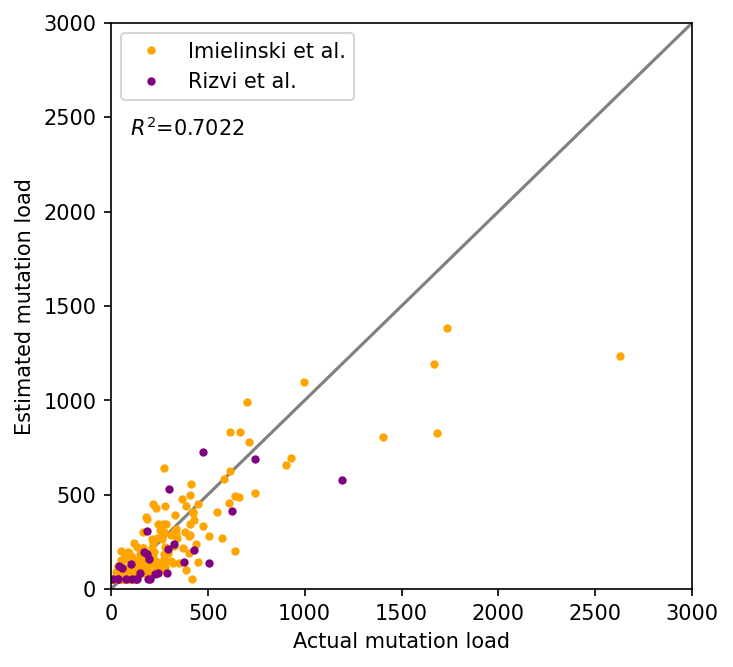

In [384]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.plot([0, 3000], [0, 3000], linestyle='-', color='gray')
plt.plot(val183_mut_load, val183_pred, '.', color='orange', label='Imielinski et al.')
plt.plot(val34_mut_load, val34_pred, '.', color='purple', label='Rizvi et al.')
ax.text(100, 2400, f"$R^2$={round(concat_r2, 4)}")
plt.legend(loc='upper left')
plt.xlabel('Actual mutation load')
plt.ylabel('Estimated mutation load')
plt.axis([0, 3000, 0, 3000])

# Predict the immunotherapy response

Only data from Rizvi et al. have the relevant information.

+ Survival
+ Follow up on benefit vs no benefit

## Progression-free surval (PFS)
Progression-free survival is "the length of time during and after the treatment of a disease, such as cancer, that a patient lives with the disease but it does not get worse".

+ PFS: in months
+ Event: 1 - death; 0 - no recorded death

In [385]:
# create a dataframe to store info for pfs plot
val34_df = pd.DataFrame(val34_pred, index=val34_mutmtx.columns, columns=['MutLoad_Pred'])
val34_df['PFS'] = therapy['PFS (mos)']
val34_df['Event'] = therapy['Event']
val34_df = val34_df.sort_values(by=['MutLoad_Pred'])
val34_df = val34_df.dropna()

In [386]:
val34_df.reset_index()

index  MutLoad_Pred        PFS  Event
0     AU5884     53.997689   1.833333      1
1     WA7899     53.997689   1.900000      1
2   DM123062     53.997689   1.900000      1
3     VA7859     53.997689   6.266667      1
4   RH090935     53.997689  10.433333      0
5     NI9507     53.997689   1.866667      1
6   JB112852     53.997689   3.266667      1
7     LO5004     53.997689   6.300000      1
8     LO3793     53.997689   3.500000      1
9     DI6359     82.283333   9.800000      0
10    AL4602     85.268247   8.366667      0
11    BL3403     85.268247   6.500000      1
12    MA7027     87.231818   1.800000      1
13    GR0134    111.118331   8.300000      1
14    VA1330    122.399881   4.133333      1
15    RO3338    131.167003   2.133333      1
16     Y2087    140.592987   8.333333      1
17    ZA6505    141.014388   1.933333      1
18  SB010944    157.917090  27.300000      0
19    SC6470    187.101784   8.333333      1
20    GR4788    197.953650   1.866667      1
21     M4945    205.500998  14.600000      0
22    SC0899    214.342248  12.566667      0
23    CA9903    241.090750  14.500000      1
24  SR070761    305.870993   3.433333      1
25    TU0428    411.841596   2.066667      1
26    KA3947    527.780182   8.133333      1
27    SA9755    579.200787   8.366667      0
28    HE3202    691.118857  14.666667      0
29    RI1933    725.262075  16.600000      0

In [387]:
# define high and low estimated mutation load
high_idx = val34_df.MutLoad_Pred>np.median(val34_df.MutLoad_Pred)

# log-rank test
# survival time, number alive at beginning of interval, number of deaths at end, 
# fraction surviving, cumulative survival rate
sta_result = logrank_test(val34_df.PFS[high_idx], val34_df.PFS[~high_idx])
sta_result.p_value

0.011832712695402101

Text(0, 0.5, 'Progression-free survival (%)')

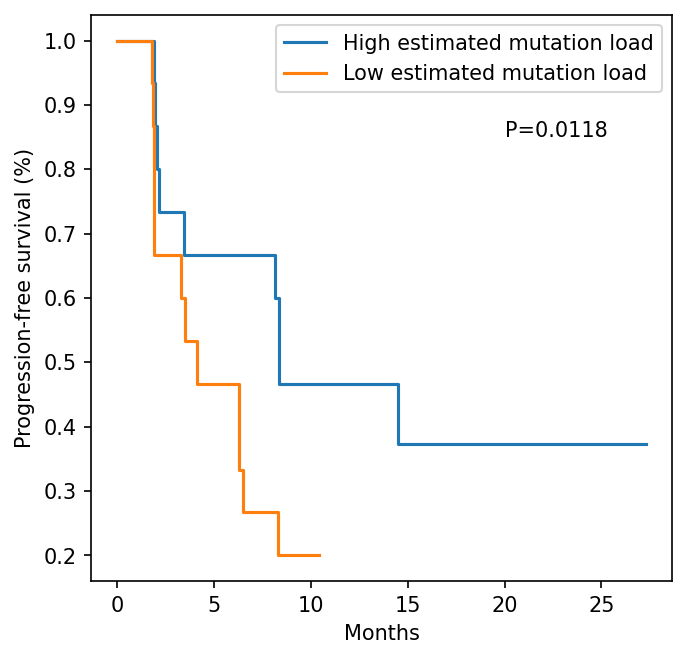

In [388]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
ax.text(20, 0.85, f"P={round(sta_result.p_value, 4)}")
kmf = KaplanMeierFitter()
kmf.fit(val34_df.PFS[high_idx], val34_df.Event[high_idx], label='High estimated mutation load')
kmf.plot(ax=ax, ci_show=False)
kmf.fit(val34_df.PFS[~high_idx], val34_df.Event[~high_idx], label='Low estimated mutation load')
kmf.plot(ax=ax, ci_show=False)
plt.xlabel('Months')
plt.ylabel('Progression-free survival (%)')

**Estimated** mutation load can predict survival rate.

Enhanced immunity after immunotherapy in patients with high mutation load may explain the difference.

## ROC (Receiver Operating Characteristic) curve

ROC curve is used to determine the discrimination threshold of DCB (durable clinical benefit) and NDB (no durable benefit).

In [389]:
val34_roc = pd.DataFrame(val34_pred, index=val34_mutmtx.columns, columns=['MutLoad_Pred'])
val34_roc['MutLoad'] = val34_mut_load
val34_roc['DCB'] = therapy['Durable Clinical Benefit']
val34_roc.DCB[val34_roc.DCB=='NR'] = np.nan
val34_roc = val34_roc.dropna()
val34_roc['y_score'] = val34_roc.MutLoad_Pred/max(val34_roc.MutLoad_Pred) # must convert to [0, 1] for ROC curve
val34_roc.DCB = val34_roc.DCB=='DCB'
val34_roc

MutLoad_Pred  MutLoad    DCB   y_score
AL4602       85.268247    244.0   True  0.117569
AU5884       53.997689     34.0  False  0.074453
BL3403       85.268247    148.0  False  0.117569
CA9903      241.090750    324.0   True  0.332419
DI6359       82.283333    228.0   True  0.113453
DM123062     53.997689    134.0  False  0.074453
GR0134      111.118331     56.0   True  0.153211
GR4788      197.953650    170.0  False  0.272941
HE3202      691.118857    746.0   True  0.952923
JB112852     53.997689    190.0  False  0.074453
KA3947      527.780182    302.0   True  0.727710
LO3793       53.997689    109.0  False  0.074453
LO5004       53.997689     79.0  False  0.074453
M4945       205.500998    427.0   True  0.283347
MA7027       87.231818    292.0  False  0.120276
NI9507       53.997689     35.0  False  0.074453
RH090935     53.997689    201.0   True  0.074453
RI1933      725.262075    473.0   True  1.000000
RO3338      131.167003    106.0  False  0.180855
SA9755      579.200787   1192.0   True  0.798609
SB010944    157.917090    198.0   True  0.217738
SC0899      214.342248    296.0   True  0.295538
SC6470      187.101784    185.0   True  0.257978
SR070761    305.870993    184.0  False  0.421739
TU0428      411.841596    626.0  False  0.567852
VA1330      122.399881     44.0  False  0.168766
VA7859       53.997689     11.0  False  0.074453
WA7899       53.997689    127.0  False  0.074453
Y2087       140.592987    507.0   True  0.193851
ZA6505      141.014388    378.0  False  0.194432

In [390]:
fpr, tpr, thresholds = roc_curve(val34_roc.DCB, val34_roc.y_score)
np.c_[fpr, tpr, thresholds]

array([[0.        , 0.        , 2.        ],
       [0.        , 0.07142857, 1.        ],
       [0.        , 0.28571429, 0.72770961],
       [0.125     , 0.28571429, 0.42173857],
       [0.125     , 0.5       , 0.28334723],
       [0.1875    , 0.5       , 0.27294085],
       [0.1875    , 0.64285714, 0.21773797],
       [0.25      , 0.64285714, 0.19443232],
       [0.25      , 0.71428571, 0.19385129],
       [0.375     , 0.71428571, 0.16876642],
       [0.375     , 0.78571429, 0.15321128],
       [0.4375    , 0.78571429, 0.12027627],
       [0.5       , 0.85714286, 0.11756888],
       [0.5       , 0.92857143, 0.11345324],
       [1.        , 1.        , 0.07445266]])

(0.0, 1.0, 0.0, 1.0)

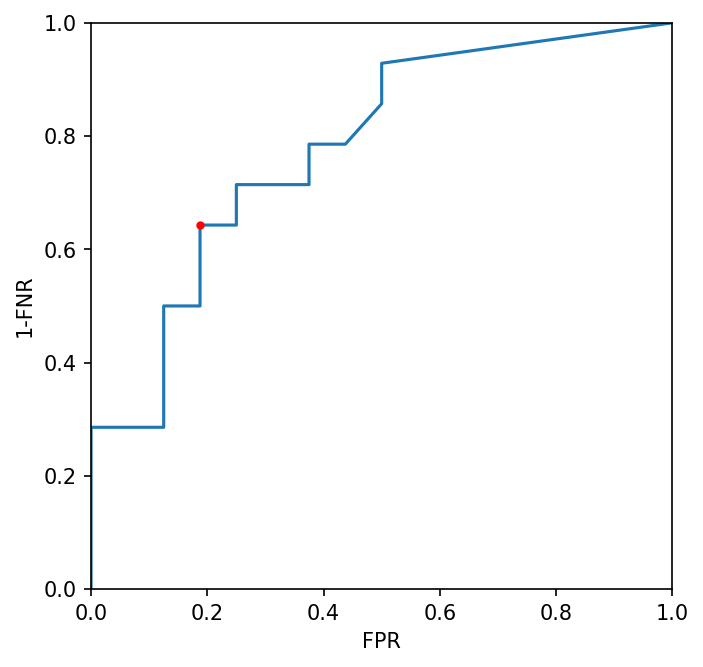

In [391]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.plot(fpr, tpr, '-')
plt.plot(0.1875, 0.64285714, '.', color='red')
plt.xlabel('FPR')
plt.ylabel('1-FNR')
plt.axis([0, 1, 0, 1])

In [392]:
# Select threshold based on ROC curve
threshold = 0.1875*max(val34_roc.MutLoad_Pred)
print("Optimal discrimination threshold:", threshold)

Optimal discrimination threshold: 135.9866390452761


In [393]:
print("AUC =", roc_auc_score(val34_roc.DCB, val34_roc.y_score))

AUC = 0.7790178571428572


## Prediction of Immunotherapy response

In [394]:
val34_roc['DCB_pred'] = val34_roc.MutLoad_Pred>=threshold
val34_roc

MutLoad_Pred  MutLoad    DCB   y_score  DCB_pred
AL4602       85.268247    244.0   True  0.117569     False
AU5884       53.997689     34.0  False  0.074453     False
BL3403       85.268247    148.0  False  0.117569     False
CA9903      241.090750    324.0   True  0.332419      True
DI6359       82.283333    228.0   True  0.113453     False
DM123062     53.997689    134.0  False  0.074453     False
GR0134      111.118331     56.0   True  0.153211     False
GR4788      197.953650    170.0  False  0.272941      True
HE3202      691.118857    746.0   True  0.952923      True
JB112852     53.997689    190.0  False  0.074453     False
KA3947      527.780182    302.0   True  0.727710      True
LO3793       53.997689    109.0  False  0.074453     False
LO5004       53.997689     79.0  False  0.074453     False
M4945       205.500998    427.0   True  0.283347      True
MA7027       87.231818    292.0  False  0.120276     False
NI9507       53.997689     35.0  False  0.074453     False
RH090935     53.997689    201.0   True  0.074453     False
RI1933      725.262075    473.0   True  1.000000      True
RO3338      131.167003    106.0  False  0.180855     False
SA9755      579.200787   1192.0   True  0.798609      True
SB010944    157.917090    198.0   True  0.217738      True
SC0899      214.342248    296.0   True  0.295538      True
SC6470      187.101784    185.0   True  0.257978      True
SR070761    305.870993    184.0  False  0.421739      True
TU0428      411.841596    626.0  False  0.567852      True
VA1330      122.399881     44.0  False  0.168766     False
VA7859       53.997689     11.0  False  0.074453     False
WA7899       53.997689    127.0  False  0.074453     False
Y2087       140.592987    507.0   True  0.193851      True
ZA6505      141.014388    378.0  False  0.194432      True

In [395]:
#Classify all the patients into 4 categories: True Positive, False Positive, True Negative and False Negative.
TP = val34_roc.loc[(val34_roc['DCB'] == True) & (val34_roc['DCB_pred'] == True)] #True Positive
FP = val34_roc.loc[(val34_roc['DCB'] == False) & (val34_roc['DCB_pred'] == True)] #False Positive
TN = val34_roc.loc[(val34_roc['DCB'] == False) & (val34_roc['DCB_pred'] == False)] #True Negative
FN = val34_roc.loc[(val34_roc['DCB'] == True) & (val34_roc['DCB_pred'] == False)] #False Negative

(0.0, 1200.0, 0.0, 1200.0)

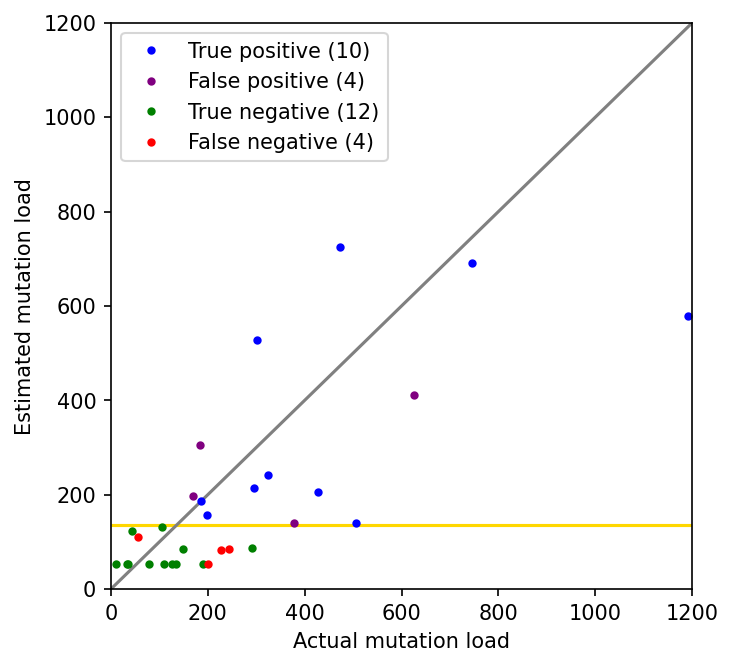

In [396]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.plot([0, 1200], [0, 1200], linestyle='-', color='gray')  #draw the diagonal

plt.plot(TP['MutLoad'], TP['MutLoad_Pred'], '.', color='blue', 
         label='True positive ({})'.format(str(TP.shape[0]))) 
plt.plot(FP['MutLoad'], FP['MutLoad_Pred'], '.', color='purple', 
         label='False positive ({})'.format(str(FP.shape[0])))
plt.plot(TN['MutLoad'], TN['MutLoad_Pred'], '.', color='green', 
         label='True negative ({})'.format(str(TN.shape[0])))
plt.plot(FN['MutLoad'], FN['MutLoad_Pred'], '.', color='red', 
         label='False negative ({})'.format(str(FN.shape[0])))

plt.hlines(threshold, 0, 1200, colors='gold', linestyles='solid') #draw the threshold line
plt.legend(loc='upper left')
plt.xlabel('Actual mutation load')
plt.ylabel('Estimated mutation load')
plt.axis([0, 1200, 0, 1200])

In [397]:
# calculate the sensitivity and specificity
sensitivity = TP.shape[0]/(TP.shape[0] + FN.shape[0]) # the ability to determine DCB correctly (true positive rate)
sensitivity

specificity = TN.shape[0]/(TN.shape[0] + FP.shape[0]) # the ability to determine NDB correctly (true negative rate)
specificity

accuracy = (TP.shape[0]+TN.shape[0])/(val34_roc.shape[0]) # a description of systematic errors
accuracy

print('The sensitivity, specificity, and accuracy of DCB/NDB classification using our constructed model were shown to be \n{}, {}, and {} respectively.'.format(
    round(sensitivity, 4), round(specificity, 4), round(accuracy, 4)))

The sensitivity, specificity, and accuracy of DCB/NDB classification using our constructed model were shown to be 
0.7143, 0.75, and 0.7333 respectively.


# Performance verification by random models

In [398]:
mutmtx_overlap = mutmtx[mutmtx.index.isin(val183_mutmtx.index) & 
                        mutmtx.index.isin(val34_mutmtx.index)]
mutmtx_overlap.head()

TCGA-05-4249-01A-01D-1105-08  TCGA-05-4382-01A-01D-1265-08  \
PLEKHN1                           1.0                           0.0   
CROCC                             1.0                           0.0   
TAS1R2                            1.0                           0.0   
USP48                             1.0                           0.0   
LPHN2                             1.0                           1.0   

         TCGA-05-4384-01A-01D-1753-08  TCGA-05-4389-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           2.0   

         TCGA-05-4390-01A-02D-1753-08  TCGA-05-4395-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           0.0   

         TCGA-05-4396-01A-21D-1855-08  TCGA-05-4398-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           1.0   

         TCGA-05-4402-01A-01D-1265-08  TCGA-05-4403-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             1.0                           0.0   

         TCGA-05-4405-01A-21D-1855-08  TCGA-05-4410-01A-21D-1855-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            1.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           1.0   

         TCGA-05-4415-01A-22D-1855-08  TCGA-05-4417-01A-22D-1855-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           1.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           0.0   

         TCGA-05-4418-01A-01D-1265-08  TCGA-05-4420-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             1.0                           0.0   

         TCGA-05-4422-01A-01D-1265-08  TCGA-05-4424-01A-22D-1855-08  \
PLEKHN1                           0.0                           0.0   
CROCC                             0.0                           0.0   
TAS1R2                            0.0                           0.0   
USP48                             0.0                           0.0   
LPHN2                             0.0                           0.0   

         TCGA-05-4425-01A-01D-1753-08  TCGA-05-4426-01A-01D-1265-08  \
PLEKHN1                           0.0                           0.0   
CROCC                   

In [399]:
val_mutmtx = pd.concat([
    val183_mutmtx[val183_mutmtx.index.isin(mutmtx_overlap.index)].reindex(mutmtx_overlap.index), 
    val34_mutmtx[val34_mutmtx.index.isin(mutmtx_overlap.index)].reindex(mutmtx_overlap.index)], axis=1)

print(val_mutmtx.shape)
val_mutmtx.head()

(3668, 211)


LUAD-5O6B5-Tumor  LUAD-B00416-Tumor  LUAD-B00523-Tumor  \
PLEKHN1               0.0                0.0                0.0   
CROCC                 0.0                0.0                1.0   
TAS1R2                0.0                0.0                1.0   
USP48                 0.0                0.0                0.0   
LPHN2                 0.0                0.0                0.0   

         LUAD-B00859-Tumor  LUAD-B00915-Tumor  LUAD-B01102-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-B01145-Tumor  LUAD-B01169-Tumor  LUAD-B01811-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                1.0   
USP48                  0.0                0.0                0.0   
LPHN2                  1.0                0.0                0.0   

         LUAD-B02077-Tumor  LUAD-B02216-Tumor  LUAD-B02477-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-B02515-Tumor  LUAD-B02594-Tumor  LUAD-D01382-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-D01603-Tumor  LUAD-D01751-Tumor  LUAD-D02185-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-E00163-Tumor  LUAD-F00018-Tumor  LUAD-F00057-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-F00089-Tumor  LUAD-F00134-Tumor  LUAD-F00257-Tumor  \
PLEKHN1                0.0                0.0                0.0   
CROCC                  0.0                0.0                0.0   
TAS1R2                 0.0                0.0                0.0   
USP48                  0.0                0.0                0.0   
LPHN2                  0.0                0.0                0.0   

         LUAD-F00365-Tumor  LUAD-F00368-Tumor  LUAD-GU4I3-Tumor  \
PLEKHN1                0.0                0.0               0.0   
CROCC                  1.0                0.0               0.0   
TAS1R2                 0.0                0.0               0.0   
USP48                  0.0                0.0               0.0   
LPHN2                  0.0                0.0               0.0   

         LUAD-LC15C-Tumor  LUAD-LIP77-Tumor  LUAD-QJN9L-Tumor  \
PLEKHN1               0.0               0.0               0.0   
CROCC                 0.0               0.0               0.0   
TAS1R2                0.0               0.0               0.0   
USP48                 0.0               0.0               0.0   
LPHN2          

In [400]:
y = mut_load.transpose()
val_mut_load = pd.concat([val183_mut_load, val34_mut_load])

n = 10000 # number of random models
m = len(model_gene)
null_r2 = np.zeros(n)

np.random.seed(1)
i = 0
while (i < n):
    j = np.random.permutation(mutmtx_overlap.shape[0])[:m]
    null_x = mutmtx_overlap.iloc[j, :].transpose()
    val_null_x = val_mutmtx.iloc[j, :].transpose()

    estimator_null = LinearRegression()
    estimator_null.fit(null_x, y)

    null_r2[i] = r2_score(val_mut_load, estimator_null.predict(val_null_x))
    if abs(null_r2[i]) <= 1:
        i += 1

In [401]:
z_sta = (concat_r2 - np.mean(null_r2)) / np.std(null_r2)
p_r2 = norm.sf(abs(z_sta))
p_r2

0.008345806937593818

Text(0, 0.5, 'Number of random models')

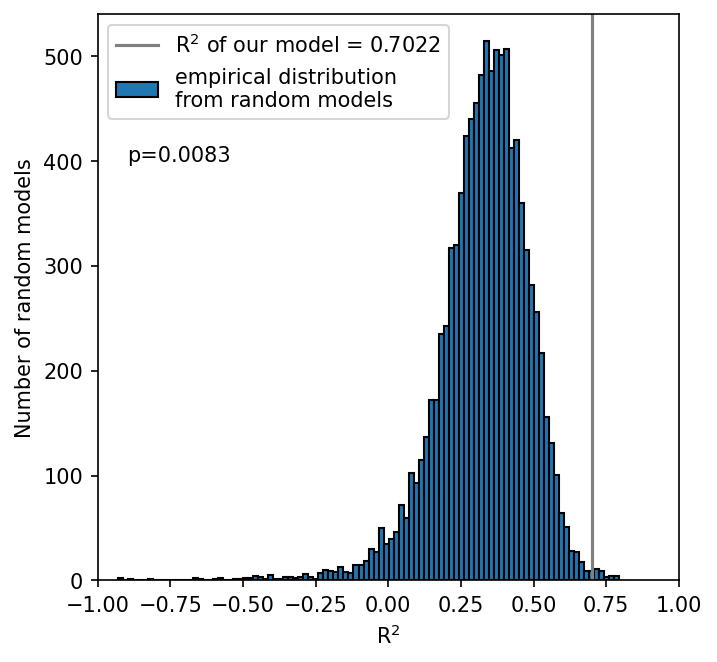

In [402]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.hist(null_r2, bins=100, edgecolor='black',
         label='empirical distribution \nfrom random models')
plt.axvline(x=concat_r2, color='gray',
            label=r'R$^2$ of our model = %.4f'%concat_r2)
plt.xlim(-1, 1)
ax.text(-0.9, 400, f"p={round(p_r2, 4)}")
plt.legend(loc='upper left')
plt.xlabel('R$^2$')
plt.ylabel('Number of random models')

# Discussion

This model-selection method can estimate the total mutation load of a patient by obtaining the sequence of only a small set of genes, which greatly reduces the cost. The estimation further predicts patients' response to immunotherapy and their survival rate.

### Future directions
Recursive feature elimination (RFE) reduces features to a smaller and smaller set. If the method integrates both forward selection and backward elimination, the model can be more robust.